_Sentiment Classification using RNN, LSTM_

1. Train a RNN based sentiment analysis model for classification of movie reviews.
    - Explore and learn about the different preprocessing steps in the Natural Language Processing(NLP) domain.
    - Apply suitable preprocessing steps for this sentiment analysis assignment.
    - Build and train a RNN model using basic layers from the framework.
    - Test model on the test set using suitable evaluation metrics.

2.  Train a LSTM based model for the same sentiment analysis problem.
    - Build and train a LSTM model using basic layers from the framework.
    - Test model on the test set using suitable evaluation metrics.

Compare between the two approaches and highlight the improvements.


- Dataset:  Stanford Sentiment Treebank 2 
- Original dataset link: https://huggingface.co/datasets/stanfordnlp/sst2 
- Dataset Zip Link: https://drive.google.com/file/d/1TytoIgt7KI9Ep9bo8bs_X0HSSnBJX0oi/


Data fields in dataset:
- idx: Monotonically increasing index ID.
- sentence: Complete sentence expressing an opinion about a film.
- label: Sentiment of the opinion, either "negative" (0) or positive (1).

Split the provided train dataset of 67349 rows into 5000 for testing and rest for training. Use the separately provided validation dataset (872 rows) file for validation.


## Question 1

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2025-03-23 20:27:35.557024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742761658.462875  134515 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742761659.155197  134515 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 20:27:45.476344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def prepare_dataset(filename):
    df=pd.read_parquet(filename)
    df['sentence']=df['sentence'].str.lower()
    df['sentence']=df['sentence'].replace(r'[^a-z0-9\s]','',regex=True)
    return df
df=prepare_dataset('./sst2_sentiment_dataset/sst2_train.parquet')
display(df)
validation_df=prepare_dataset('./sst2_sentiment_dataset/sst2_valid.parquet')
display(validation_df)

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,contains no wit only labored gags,0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revengeofthenerds clichs the film...,0
...,...,...,...
67344,67344,a delightful comedy,1
67345,67345,anguish anger and frustration,0
67346,67346,at achieving the modest crowdpleasing goals i...,1
67347,67347,a patient viewer,1


,idx,sentence,label
0,0,it s a charming and often affecting journey,1
1,1,unflinchingly bleak and desperate,0
2,2,allows us to hope that nolan is poised to emba...,1
3,3,the acting costumes music cinematography an...,1
4,4,it s slow very very slow,0
...,...,...,...
867,867,has all the depth of a wading pool,0
868,868,a movie with a real anarchic flair,1
869,869,a subject like this should inspire reaction in...,0
870,870,is an arthritic attempt at directing by calli...,0


In [3]:
vocab_length = 10000  
max_length = 10

X_train,X_test,y_train,y_test=train_test_split(df['sentence'],df['label'],test_size=0.07424015204383138576667805015665)

train_df=pd.DataFrame({'sentence':X_train,'label':y_train})
test_df=pd.DataFrame({'sentence':X_test,'label':y_test})

display(train_df.shape)
display(test_df.shape)
display(validation_df.shape)

tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=vocab_length,oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['sentence'])

train_sequences=tokenizer.texts_to_sequences(train_df['sentence'])
test_sequences=tokenizer.texts_to_sequences(test_df['sentence'])
val_sequences=tokenizer.texts_to_sequences(validation_df['sentence'])


train_padded=tf.keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating='post')
test_padded=tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length,padding='post',truncating='post')
val_padded=tf.keras.preprocessing.sequence.pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating='post')

train_labels = train_df['label'].values
test_labels = test_df['label'].values
val_labels = validation_df['label'].values

print("Example raw text:", train_df['sentence'][0])  # Check an example review
print("Tokenized sequence:", train_sequences[0])  # Check tokenized output
print("Padded sequence:", train_padded[0])  # Check if padding is applied correctly

(62349, 2)

(5000, 2)

(872, 3)

Example raw text: hide new secretions from the parental units 
Tokenized sequence: [2, 42, 312, 3, 4469, 6760, 5, 1]
Padded sequence: [   2   42  312    3 4469 6760    5    1    0    0]


In [4]:
class BasicRNNCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BasicRNNCell, self).__init__()
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_x = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", trainable=True)
        self.W_h = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

    def call(self, inputs, states):
        prev_hidden = states[0]
        new_hidden = tf.nn.relu(tf.matmul(inputs, self.W_x) + tf.matmul(prev_hidden, self.W_h) + self.b)
        return new_hidden, [new_hidden]

class CustomRNN(tf.keras.layers.RNN):
    def __init__(self, units):
        cell = BasicRNNCell(units)
        super().__init__(cell, return_sequences=False, return_state=False)

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, 64, input_length=max_length),
    CustomRNN(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/mnt/c/Users/Falcon/Desktop/DL/tf_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1742761739.600390  134515 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_rnn (CustomRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels), batch_size=32)

Epoch 1/10


I0000 00:00:1742761743.308804  134917 service.cc:148] XLA service 0x7ff5c400bbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742761743.309262  134917 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-03-23 20:29:03.943465: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742761745.406418  134917 cuda_dnn.cc:529] Loaded cuDNN version 90300


  23/1949 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5378 - loss: 0.6906  

I0000 00:00:1742761749.775652  134917 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1949/1949 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.7395 - loss: 0.4908 - val_accuracy: 0.7626 - val_loss: 0.5487
Epoch 2/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8994 - loss: 0.2352 - val_accuracy: 0.7729 - val_loss: 0.5306
Epoch 3/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9146 - loss: 0.1926 - val_accuracy: 0.7729 - val_loss: 0.6000
Epoch 4/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9247 - loss: 0.1638 - val_accuracy: 0.7901 - val_loss: 0.7254
Epoch 5/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9402 - loss: 0.1362 - val_accuracy: 0.7833 - val_loss: 0.7853
Epoch 6/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9457 - loss: 0.1202 - val_accuracy: 0.7706 - val_loss: 0.7018
Epoch 7/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9489 - loss: 0.1062 - val_accuracy: 0.7741 - val_loss: 0.7682
Epoch 8/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9537 - loss: 0.0992 - va

In [7]:
display(test_df['label'].value_counts())

label
1    2844
0    2156
Name: count, dtype: int64

In [8]:
predictions=model.predict(test_padded)

predicted_labels = (predictions > 0.5).astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [9]:
test_labels = test_df['label'].values
report = classification_report(test_labels, predicted_labels, target_names=["Negative", "Positive"])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.88      2156
    Positive       0.92      0.89      0.90      2844

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



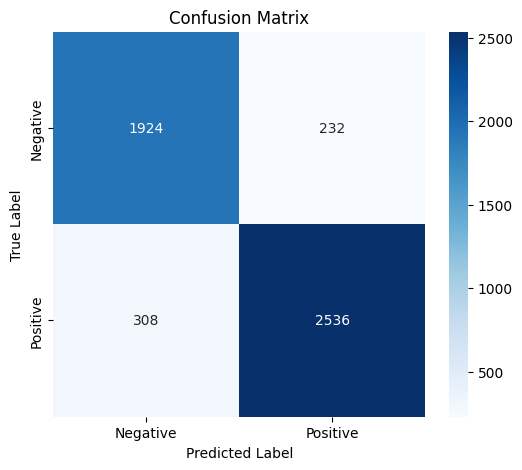

In [10]:
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Question 2

In [ ]:
class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CustomLSTMCell, self).__init__()
        self.units = units
        self.state_size = [units, units]

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_f = self.add_weight(shape=(input_dim + self.units, self.units), initializer="random_normal", trainable=True)
        self.b_f = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

        self.W_i = self.add_weight(shape=(input_dim + self.units, self.units), initializer="random_normal", trainable=True)
        self.b_i = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

        self.W_c = self.add_weight(shape=(input_dim + self.units, self.units), initializer="random_normal", trainable=True)
        self.b_c = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

        self.W_o = self.add_weight(shape=(input_dim + self.units, self.units), initializer="random_normal", trainable=True)
        self.b_o = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

    def call(self, inputs, states):
        h_prev, c_prev = states
        combined = tf.concat([inputs, h_prev], axis=1)

        # Forget gate
        f_t = tf.sigmoid(tf.matmul(combined, self.W_f) + self.b_f)

        # Input gate
        i_t = tf.sigmoid(tf.matmul(combined, self.W_i) + self.b_i)
        c_tilde = tf.tanh(tf.matmul(combined, self.W_c) + self.b_c)

        # Cell state update
        c_t = f_t * c_prev + i_t * c_tilde

        # Output gate
        o_t = tf.sigmoid(tf.matmul(combined, self.W_o) + self.b_o)
        h_t = o_t * tf.tanh(c_t)

        return h_t, [h_t, c_t]
    
class CustomLSTM(tf.keras.layers.RNN):
    def __init__(self, units):
        cell = CustomLSTMCell(units)
        super().__init__(cell, return_sequences=False, return_state=False)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, 128, input_length=max_length),
    CustomLSTM(128),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/mnt/c/Users/Falcon/Desktop/DL/tf_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm (CustomLSTM)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels), batch_size=32)

Epoch 1/10


2025-03-23 20:32:12.490731: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56', 28 bytes spill stores, 32 bytes spill loads



1949/1949 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.7570 - loss: 0.4736 - val_accuracy: 0.7741 - val_loss: 0.4831
Epoch 2/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9031 - loss: 0.2313 - val_accuracy: 0.7741 - val_loss: 0.5242
Epoch 3/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9301 - loss: 0.1661 - val_accuracy: 0.7638 - val_loss: 0.5958
Epoch 4/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9444 - loss: 0.1331 - val_accuracy: 0.7787 - val_loss: 0.5984
Epoch 5/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9547 - loss: 0.1059 - val_accuracy: 0.7661 - val_loss: 0.6925
Epoch 6/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9607 - loss: 0.0870 - val_accuracy: 0.7821 - val_loss: 0.7640
Epoch 7/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9653 - loss: 0.0774 - val_accuracy: 0.7638 - val_loss: 0.9265
Epoch 8/10
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9695 - loss: 0.0657 - va

In [14]:
predictions=model.predict(test_padded)

predicted_labels = (predictions > 0.5).astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [15]:
test_labels = test_df['label'].values
report = classification_report(test_labels, predicted_labels, target_names=["Negative", "Positive"])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.92      0.89      2156
    Positive       0.93      0.88      0.91      2844

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



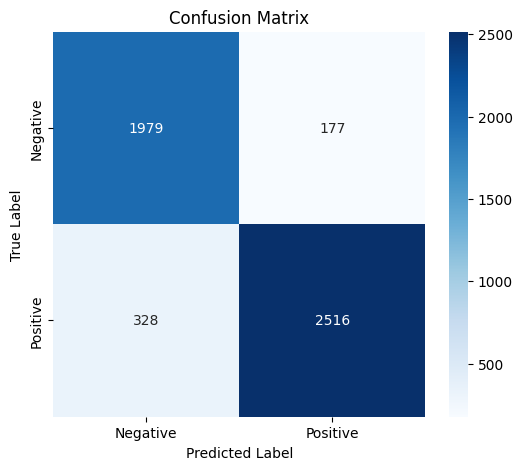

In [16]:
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()